In [119]:
import mne
import matplotlib 
import matplotlib.pyplot as plt
# matplotlib.use('Qt5Agg')
from mne.preprocessing import ICA
from mne.preprocessing import read_ica
raw = mne.io.read_raw_fif('rEEG\sub-095\preICA095_raw.fif', preload=True)
ica = read_ica(f'rEEG\sub-095\ica-095-variance_compica.fif')

Opening raw data file rEEG\sub-095\preICA095_raw.fif...
    Range : 0 ... 30834 =      0.000 ...   123.336 secs
Ready.
Reading 0 ... 30834  =      0.000 ...   123.336 secs...
Reading c:\Users\User\Documents\EEG_Project\rEEG\sub-095\ica-095-variance_compica.fif ...
Now restoring ICA solution ...
Ready.


C:\Users\User\AppData\Local\Temp\ipykernel_15732\3134218908.py:8: RuntimeWarning: This filename (rEEG\sub-095\ica-095-variance_compica.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = read_ica(f'rEEG\sub-095\ica-095-variance_compica.fif')


In [ ]:
figs = ica.plot_components()

In [ ]:
ica.plot_sources(raw, show_scrollbars=True)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


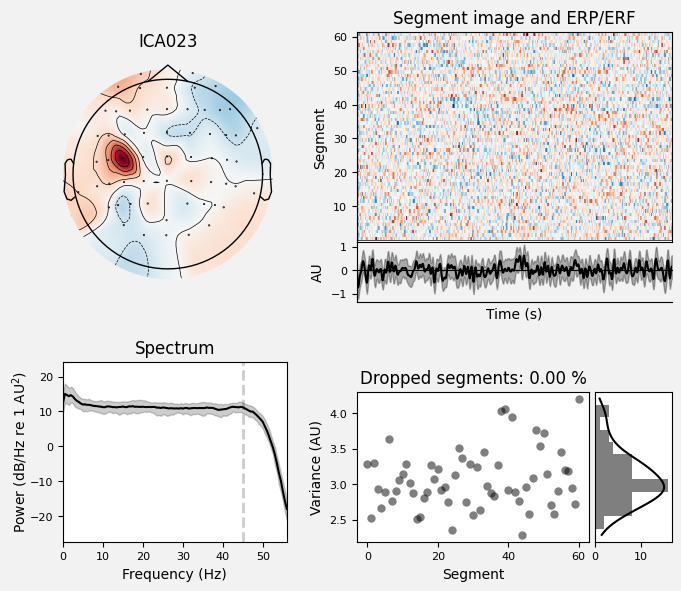

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


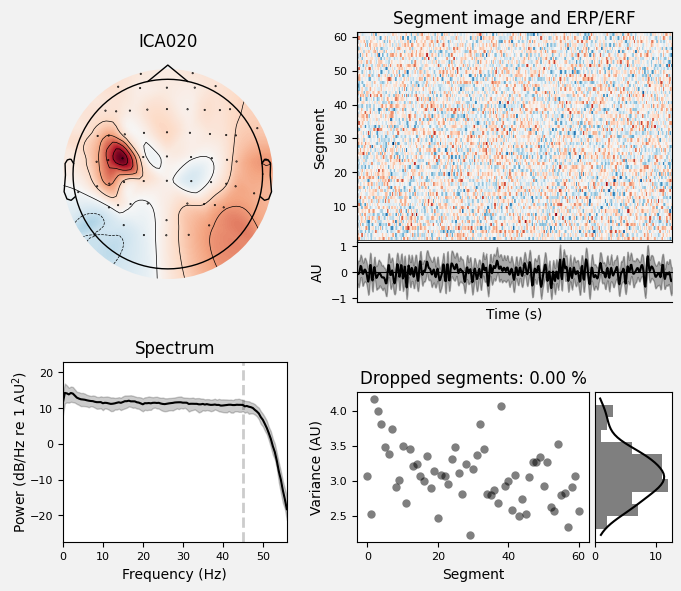

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


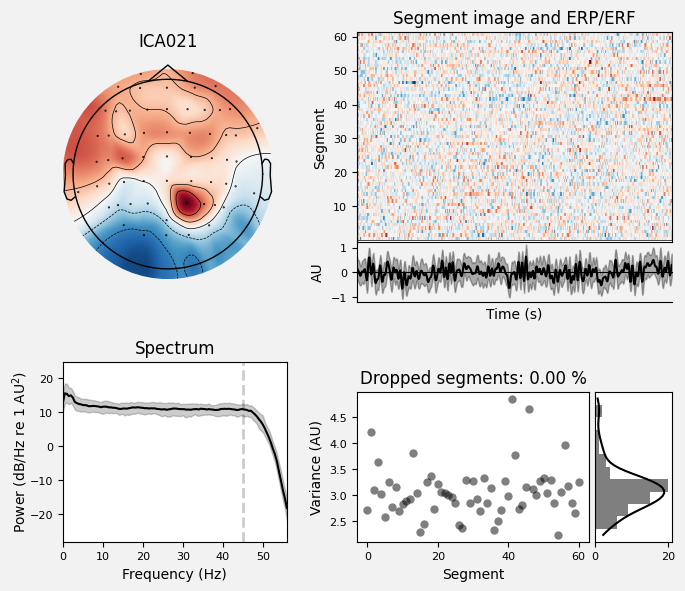

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


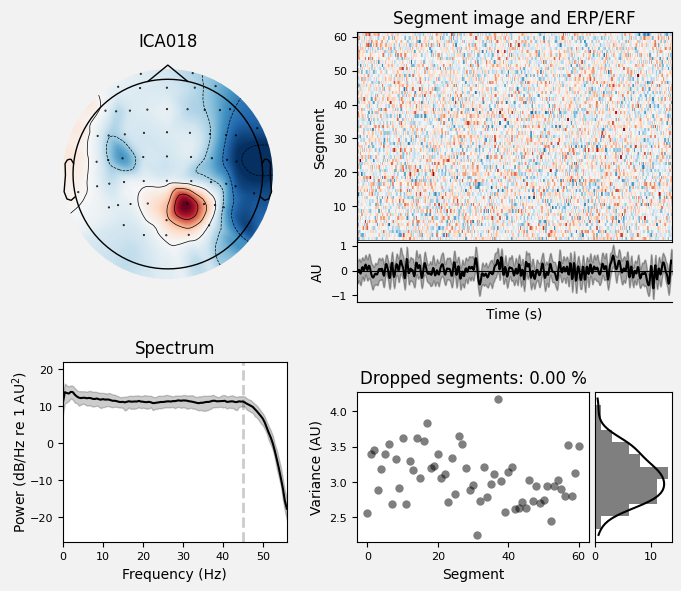

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


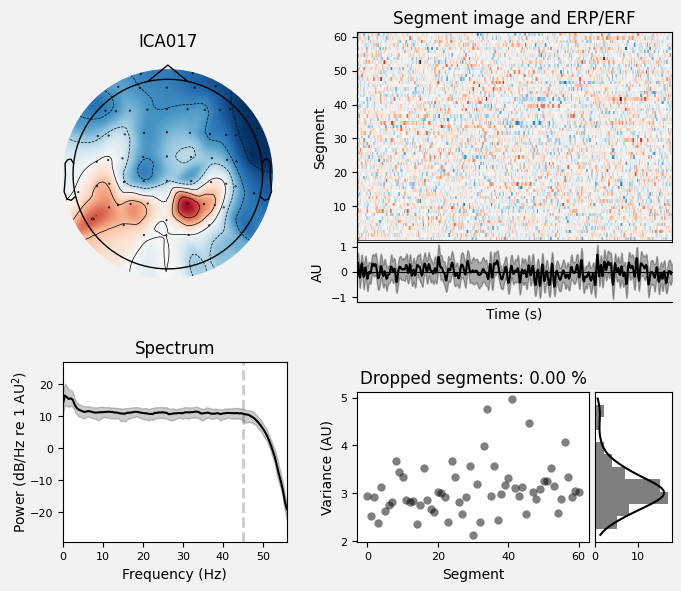

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


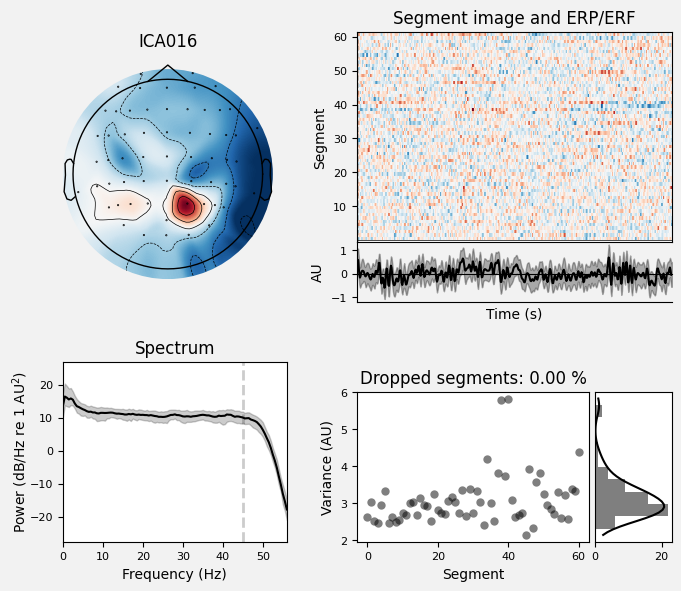

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


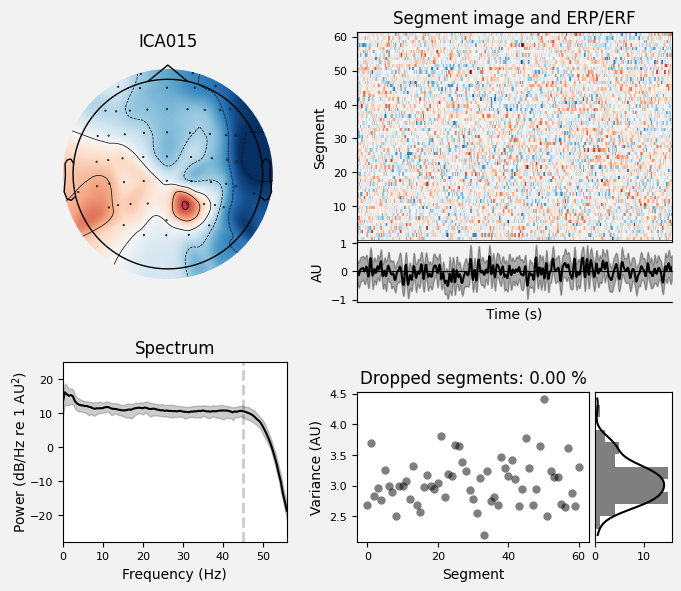

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


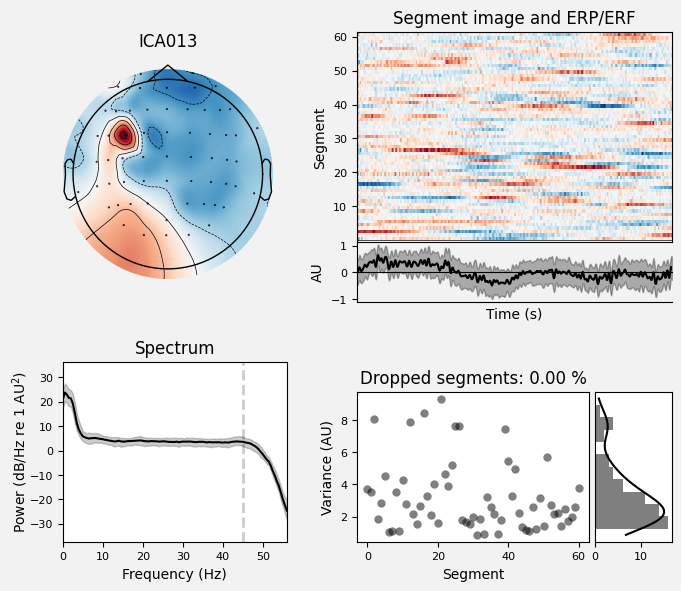

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


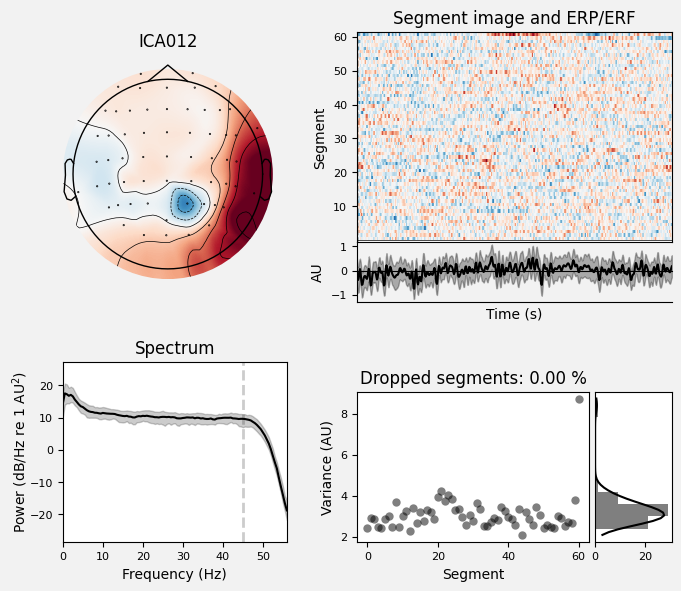

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


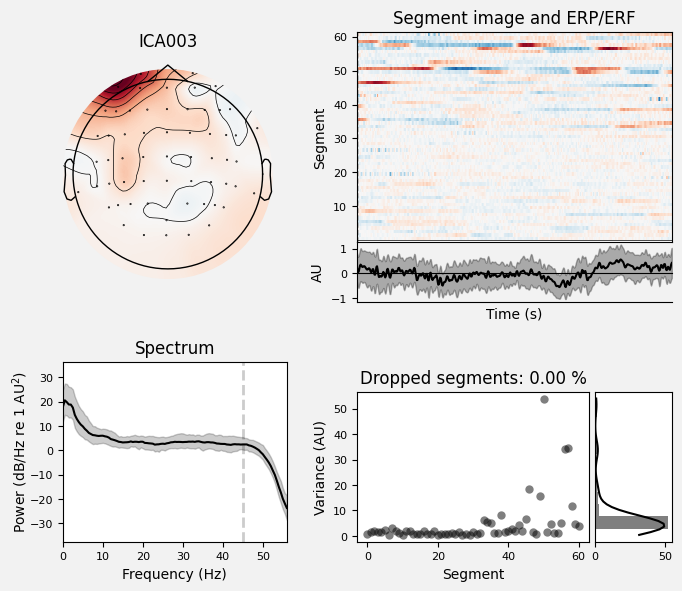

In [120]:
for comp in [23,20,21,18,17,16,15,13,12,3]:
    ica.plot_properties(raw, picks=comp)

### Visualization

In [ ]:
for comp in range(0,25):
    ica.plot_properties(raw, picks=comp)

In [ ]:
ica.plot_components([0]) 

### Z-SCORE/KURTOSIS FOR MUSCLE ARTIFACTS

In [ ]:
# inputs assumed: raw (preprocessed), ica (fitted ICA object)
import numpy as np
from scipy.stats import kurtosis, zscore
from mne.time_frequency import psd_array_welch
from mne.filter import filter_data

sf = raw.info['sfreq']
src = ica.get_sources(raw).get_data()   # (n_comps, n_samples)
n_comps = src.shape[0]

def spectral_slope(f, Pxx, fmin=2., fmax=45.):
    mask = (f >= fmin) & (f <= fmax)
    xf = np.log(f[mask] + 1e-12)
    yf = np.log(Pxx[mask] + 1e-12)
    # robust-ish linear fit
    A = np.vstack([xf, np.ones_like(xf)]).T
    m, c = np.linalg.lstsq(A, yf, rcond=None)[0]
    return m  # slope (more negative = steeper, less HF)

# metrics storage
band_ratio = np.zeros(n_comps)
hf_power = np.zeros(n_comps)
tot_power = np.zeros(n_comps)
kurt_vals = np.zeros(n_comps)
rms_burst_frac = np.zeros(n_comps)
slope_vals = np.zeros(n_comps)

# parameters
hf_band = (15., 45.)        # muscle typical HF band
psd_fmin, psd_fmax = 1., sf/2.
n_fft = 2048

for i in range(0, 55):
    ic = src[i, :]
    # PSD
    f, Pxx = psd_array_welch(ic, sfreq=sf, fmin=psd_fmin, fmax=psd_fmax, n_fft=n_fft)
    mask_hf = (f >= hf_band[0]) & (f <= hf_band[1])
    hf_power[i] = Pxx[mask_hf].mean()
    tot_power[i] = Pxx.mean() + 1e-12
    band_ratio[i] = hf_power[i] / tot_power[i]
    # kurtosis (time domain)
    kurt_vals[i] = kurtosis(ic, fisher=False, nan_policy='omit')  # Pearson definition
    # spectral slope
    slope_vals[i] = spectral_slope(f, Pxx, fmin=2., fmax=45.)
    # envelope burstiness: bandpass then RMS + fraction above threshold
    try:
        bp = filter_data(ic[np.newaxis, :], sf, l_freq=hf_band[0], h_freq=hf_band[1], verbose=False)[0]
        env = np.abs(bp)
        window = int(0.05 * sf) or 1   # 50 ms RMS window
        # moving RMS
        rms = np.sqrt(np.convolve(env**2, np.ones(window)/window, mode='same'))
        thr = np.median(rms) + 2*np.std(rms)
        rms_burst_frac[i] = np.mean(rms > thr)
    except Exception:
        rms_burst_frac[i] = 0.0

# normalize by zscore across components (robust option: use median/MAD if preferred)
z_band = zscore(band_ratio, nan_policy='omit')
z_kurt = zscore(kurt_vals, nan_policy='omit')
z_rms = zscore(rms_burst_frac, nan_policy='omit')
z_slope = zscore(-slope_vals, nan_policy='omit')  # invert slope: less negative -> more HF -> positive

# combine flags: flag if any metric extreme (tunable threshold)
th = 2.5  # z-score threshold (adjustable)
flag_mask = (z_band > th) | (z_kurt > th) | (z_rms > th) | (z_slope > th)

muscle_candidates = np.where(flag_mask)[0].tolist()

# show summary per flagged IC
for ic_idx in muscle_candidates:
    print(f"IC{ic_idx}: band_ratio={band_ratio[ic_idx]:.3f}, z_band={z_band[ic_idx]:.2f}, "
          f"kurt={kurt_vals[ic_idx]:.2f}, z_kurt={z_kurt[ic_idx]:.2f}, "
          f"rms_frac={rms_burst_frac[ic_idx]:.3f}, z_rms={z_rms[ic_idx]:.2f}, "
          f"slope_z={z_slope[ic_idx]:.2f}")

print("Flagged muscle ICs:", muscle_candidates)
